## 1. 加载数据并进行预处理
### 此单元格从CSV文件 (events.csv) 加载事件数据到pandas DataFrame，并显示前几行以检查数据的结构。

In [33]:
import pandas as pd

data = pd.read_csv('events.csv')

data.head()


,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


## 2. 转换时间戳并编码分类数据

In [23]:

data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['visitorid'] = label_encoder.fit_transform(data['visitorid'])
data['itemid'] = label_encoder.fit_transform(data['itemid'])

data['event'] = data['event'].map({'view': 0, 'cart': 1, 'purchase': 2})

data['transactionid'] = data['transactionid'].fillna(0)

data['hour'] = data['timestamp'].dt.hour
data['dayofweek'] = data['timestamp'].dt.dayofweek

data.head()


,timestamp,visitorid,event,itemid,transactionid,hour,dayofweek
0,2015-06-02 05:02:12.117,257597,0.0,179333,0.0,5,1
1,2015-06-02 05:50:14.164,992329,0.0,125263,0.0,5,1
2,2015-06-02 05:13:19.827,111016,0.0,160653,0.0,5,1
3,2015-06-02 05:12:35.914,483717,0.0,127563,0.0,5,1
4,2015-06-02 05:02:17.106,951259,0.0,185159,0.0,5,1


## 3. 准备特征并拆分数据集

In [24]:

features = ['visitorid', 'itemid', 'hour', 'dayofweek']
X = data[features].values
y = data['event'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 4. 定义网络模型

In [25]:
import torch
import torch.nn as nn

class UserBehaviorModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(UserBehaviorModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  
        return out

input_size = len(features) 
hidden_size = 50  
output_size = 3 


model = UserBehaviorModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size)


## 5. 检查并处理 event 列的缺失数据

In [26]:

print(data['event'].unique())

print(data['event'].isna().sum())


[ 0. nan]
91789


In [27]:

data['event'] = data['event'].fillna(0).astype(int)

print(data['event'].isna().sum())

assert all(data['event'].isin([0, 1, 2]))


0


## 6. 数据归一化并准备张量

In [28]:

X = data[features].values
y = data['event'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.Tensor(X_train).unsqueeze(1) 
y_train_tensor = torch.LongTensor(y_train)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


## 7. 训练模型并跟踪损失值

Epoch [10/200], Train Loss: 1.0906, Val Loss: 1.0858
Epoch [20/200], Train Loss: 1.0421, Val Loss: 1.0371
Epoch [30/200], Train Loss: 0.9898, Val Loss: 0.9843
Epoch [40/200], Train Loss: 0.9310, Val Loss: 0.9247
Epoch [50/200], Train Loss: 0.8638, Val Loss: 0.8566
Epoch [60/200], Train Loss: 0.7876, Val Loss: 0.7796
Epoch [70/200], Train Loss: 0.7033, Val Loss: 0.6946
Epoch [80/200], Train Loss: 0.6133, Val Loss: 0.6042
Epoch [90/200], Train Loss: 0.5216, Val Loss: 0.5127
Epoch [100/200], Train Loss: 0.4331, Val Loss: 0.4248
Epoch [110/200], Train Loss: 0.3524, Val Loss: 0.3450
Epoch [120/200], Train Loss: 0.2826, Val Loss: 0.2764
Epoch [130/200], Train Loss: 0.2250, Val Loss: 0.2200
Epoch [140/200], Train Loss: 0.1793, Val Loss: 0.1754
Epoch [150/200], Train Loss: 0.1438, Val Loss: 0.1408
Epoch [160/200], Train Loss: 0.1166, Val Loss: 0.1143
Epoch [170/200], Train Loss: 0.0958, Val Loss: 0.0940
Epoch [180/200], Train Loss: 0.0797, Val Loss: 0.0784
Epoch [190/200], Train Loss: 0.0673, 

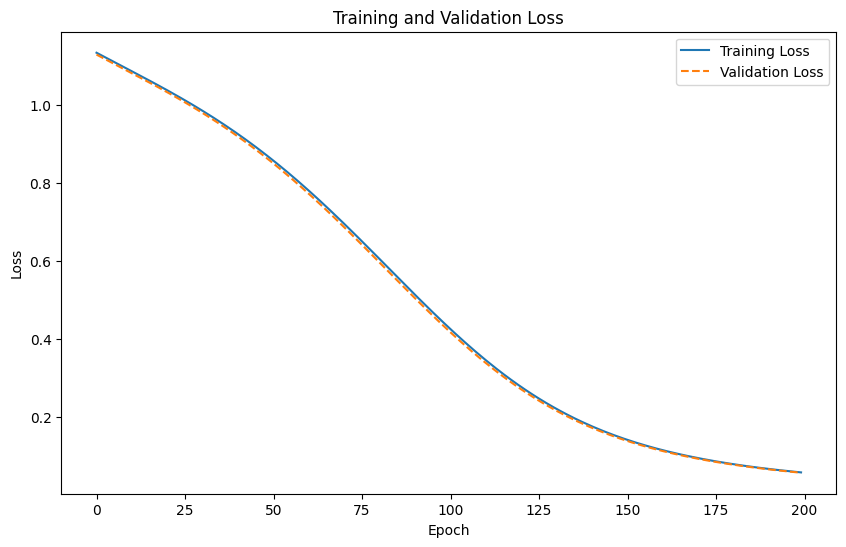

In [29]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X = data[features].values
y = data['event'].values

# 分割数据：80% 训练集，10% 验证集，10% 测试集
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


X_train_tensor = torch.Tensor(X_train).unsqueeze(1)  
y_train_tensor = torch.LongTensor(y_train)

X_val_tensor = torch.Tensor(X_val).unsqueeze(1) 
y_val_tensor = torch.LongTensor(y_val)

model = UserBehaviorModel(input_size=len(features), hidden_size=50, output_size=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 200
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    outputs_train = model(X_train_tensor)
    loss_train = criterion(outputs_train, y_train_tensor)
    loss_train.backward()
    optimizer.step()

    train_losses.append(loss_train.item())
    
    model.eval()
    with torch.no_grad():
        outputs_val = model(X_val_tensor)
        loss_val = criterion(outputs_val, y_val_tensor)
        val_losses.append(loss_val.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss_train.item():.4f}, Val Loss: {loss_val.item():.4f}')

plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label="Training Loss")
plt.plot(range(epochs), val_losses, label="Validation Loss", linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


## 8. 在测试数据上评估模型性能

In [30]:

model.eval()
X_test_tensor = torch.Tensor(X_test).unsqueeze(1)
y_test_tensor = torch.LongTensor(y_test)

y_pred = model(X_test_tensor)
_, predicted = torch.max(y_pred, 1)

from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test_tensor, predicted)
f1 = f1_score(y_test_tensor, predicted, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 1.0000
F1 Score: 1.0000


## 9. 保存模型

In [31]:

torch.save(model.state_dict(), 'user_behavior_model.pth')


## 11. 将模型转换为ONNX格式

In [ ]:
import torch
import torch.onnx

class UserBehaviorModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(UserBehaviorModel, self).__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 只取最后一个时间步的输出
        return out

model = UserBehaviorModel(input_size=len(features), hidden_size=50, output_size=3)  # 根据你的模型参数调整

model.load_state_dict(torch.load('user_behavior_model.pth'))

model.eval()

dummy_input = torch.randn(1, 1, 8)  

onnx_file_path = "model.onnx"
torch.onnx.export(model, dummy_input, onnx_file_path, verbose=True)


Exported graph: graph(%onnx::Transpose_0 : Float(1, 1, 8, strides=[8, 8, 1], requires_grad=0, device=cpu),
      %fc.weight : Float(3, 50, strides=[50, 1], requires_grad=1, device=cpu),
      %fc.bias : Float(3, strides=[1], requires_grad=1, device=cpu),
      %onnx::LSTM_117 : Float(1, 200, 4, strides=[800, 4, 1], requires_grad=0, device=cpu),
      %onnx::LSTM_118 : Float(1, 200, 50, strides=[10000, 50, 1], requires_grad=0, device=cpu),
      %onnx::LSTM_119 : Float(1, 400, strides=[400, 1], requires_grad=0, device=cpu)):
  %/lstm/Constant_output_0 : Float(1, 1, 50, strides=[50, 50, 1], requires_grad=0, device=cpu) = onnx::Constant[value=<Tensor>, onnx_name="/lstm/Constant"](), scope: __main__.UserBehaviorModel::/torch.nn.modules.rnn.LSTM::lstm # /root/miniconda3/lib/python3.10/site-packages/torch/nn/modules/rnn.py:854:0
  %/lstm/Transpose_output_0 : Float(1, 1, 8, strides=[8, 8, 1], device=cpu) = onnx::Transpose[perm=[1, 0, 2], onnx_name="/lstm/Transpose"](%onnx::Transpose_0), scope

/root/miniconda3/lib/python3.10/site-packages/torch/onnx/symbolic_opset9.py:4662: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(
